# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

In [ ]:
#Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')
import yfinance as yf
import scipy.stats as stats

In [ ]:
tickers = ['GM','AMZN', 'MSFT', 'GOOG', 'HD']

#last financial year
start_date = dt.datetime.today() - dt.timedelta(days = 252*5)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)

/tmp/ipython-input-30-1039701978.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start = start_date, end = end_date)
[*********************100%***********************]  5 of 5 completed


In [ ]:
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

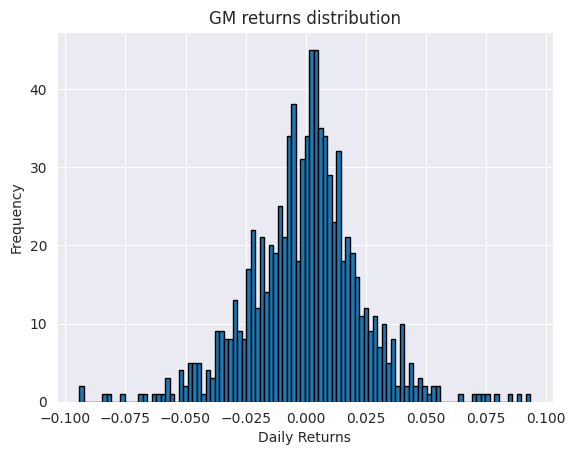

In [ ]:
plt.hist(daily_returns[tickers[0]], bins=100, edgecolor='black')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('GM returns distribution')
plt.show()

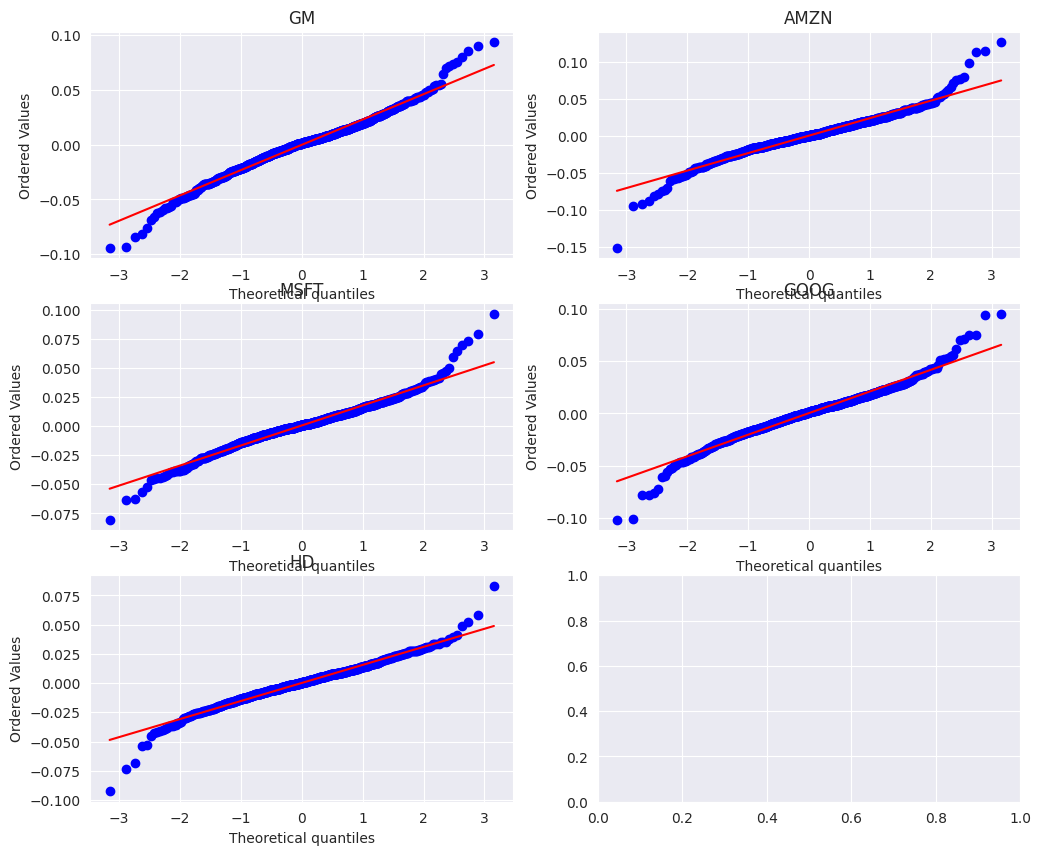

In [ ]:
fig, axes = plt.subplots(len(tickers)//2 + len(tickers)%2, 2, figsize=(12, 10))


for ticker in tickers:
  stats.probplot(daily_returns[ticker], dist="norm", plot=axes.flatten()[tickers.index(ticker)])
  axes.flatten()[tickers.index(ticker)].set_title(ticker, fontsize=12)
plt.show()

In [ ]:
#deviations from normalcy!
p_arr = np.array([])
for ticker in tickers:
  p_arr = np.append(p_arr,stats.normaltest(daily_returns[ticker])[1])
  print(ticker,p_arr[-1])
  if(p_arr[-1]<0.05):
    print('Evidence for non-normal distribution')
  else:
    print('No evidence for non-normal distribution')

GM 8.502358618383537e-09
Evidence for non-normal distribution
AMZN 2.4824690410845764e-21
Evidence for non-normal distribution
MSFT 3.6863232774072506e-15
Evidence for non-normal distribution
GOOG 2.9007675292326313e-15
Evidence for non-normal distribution
HD 2.4316004329774976e-19
Evidence for non-normal distribution


Let us now remove the extremal values to see if they get close to normalcy! We will get the standard deviation of the approximate distribution and we will get rid of data lying outside the 2*standard deviation interval.

GM 0.18950459800411512
No evidence for non-normal distribution after extreme data removal


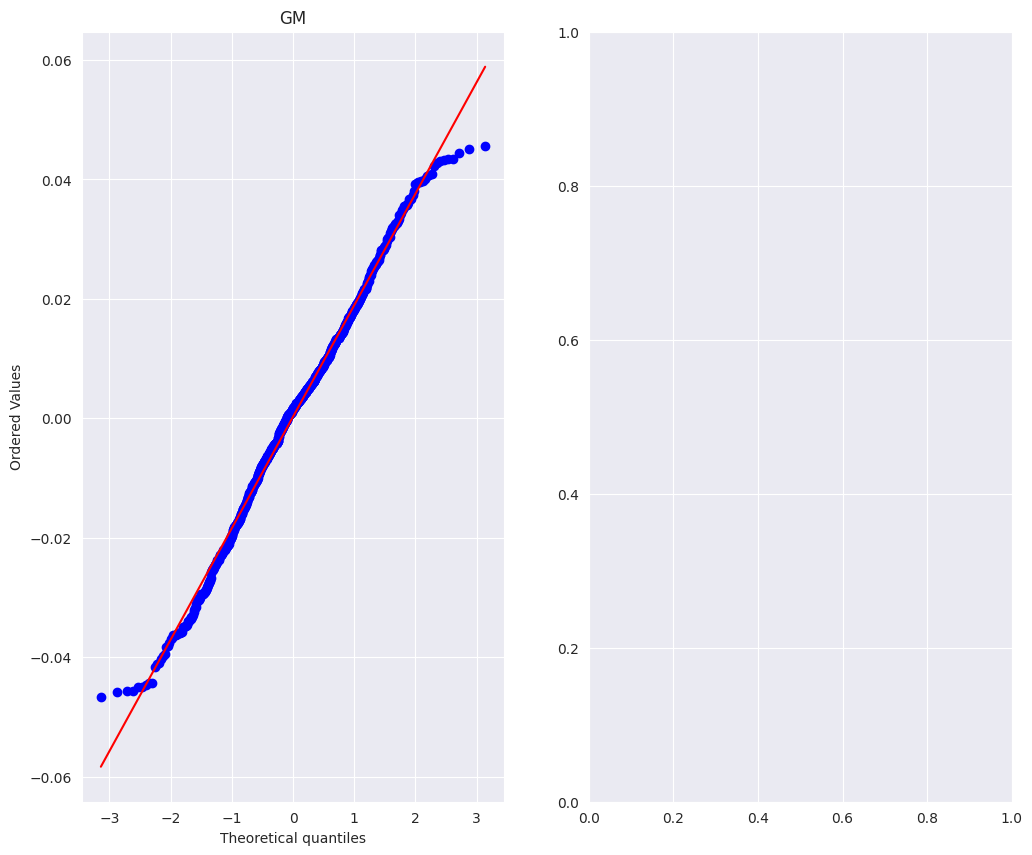

In [ ]:
fig, axes = plt.subplots(len(tickers)//2 + len(tickers)%2, 2, figsize=(12, 10))
p_arr = np.array([])
for ticker in tickers:
  array = np.array(daily_returns[ticker])
  mean = np.mean(array)
  std = np.std(array)
  array = array[(array>mean-2*std) & (array<mean+2*std)]
  stats.probplot(array, dist="norm", plot=axes.flatten()[tickers.index(ticker)])
  axes.flatten()[tickers.index(ticker)].set_title(ticker, fontsize=12)

  p_arr = np.append(p_arr,stats.normaltest(array)[1])
  print(ticker,p_arr[-1])
  if(p_arr[-1]<0.05):
    print('Evidence for non-normal distribution after extreme data removal')
  else:
    print('No evidence for non-normal distribution after extreme data removal')

plt.show()


Creating a portfolio with normally distributed stocks

In [ ]:
new_tickers = []
flag = 0
for ticker in tickers:
  array = np.array(daily_returns[ticker])
  mean = np.mean(array)
  std = np.std(array)
  array = array[(array>mean-2*std) & (array<mean+2*std)]
  if(stats.normaltest(array)[1]>0.05):
    new_tickers.append(ticker)
    flag = 1
  else:
    continue

if(flag==0):
  print("No stock added to the new list!")
print(new_tickers)

['GM']


Creating a new portfolio with "normal" stocks

In [ ]:
print(new_tickers)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(5*252) for ticker in new_tickers}
# Calculate the covariance matrix
new_daily_returns = daily_returns[new_tickers]
covariance_matrix = 5*252*((new_daily_returns.cov()))
# Number of assets
n_assets = len(new_tickers)
print(n_assets)
# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets]*n_assets)

constraints1 = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-0.1},
               {'type': 'ineq', 'fun': lambda weights: 0.35-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(covariance_matrix,weights)))
    return portfolio_std_dev


#low_risk
result_low_risk = minimize(portfolio_volatility, initial_weights, method='SLSQP', constraints=constraints1)

# Optimal asset weights
optimal_weights = result_low_risk.x
optimal_vol = result_low_risk.fun
print(optimal_weights)
print(optimal_vol)

['GM']
1
[1.]
0.8260988658155409


Checking how the "normalcy" varies as a function of the year for different stocks in the last five years.

In [ ]:
years = 5
for n in range(0,years):
  start_date = dt.datetime(2025 - n, 6, 26) - dt.timedelta(days = 252)
  end_date = dt.datetime.today()
  stock = yf.download(tickers[0], start = start_date, end = end_date)
  daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
  daily_returns = daily_returns.dropna()
  array = np.array(daily_returns[tickers[0]])
  mean = np.mean(array)
  std = np.std(array)
  array = array[(array>mean-3*std) & (array<mean+3*std)]
  if(stats.normaltest(array)[1]>0.05):
    print('No evidence for non-normal distribution in year', years - n)
  else:
    print('Evidence for non-normal distribution in year', years - n)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


No evidence for non-normal distribution in year 5
Evidence for non-normal distribution in year 4


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Evidence for non-normal distribution in year 3
Evidence for non-normal distribution in year 2


[*********************100%***********************]  1 of 1 completed

No evidence for non-normal distribution in year 1
